## Sentiment Analysis of Google Play Store App Reviews
The Google Play Store Apps dataset contains thousands of user reviews for apps available on the Google Play Store (Android). I'll be performing sentiment analysis on these reviews to look at the overall positive/neutral/negative sentiment of various apps, as well as frequently used words. 

In [12]:
suppressMessages(library(tidyverse))
suppressMessages(library(tidytext))
suppressMessages(library(ggplot2))
suppressMessages(library(ggpubr))
suppressMessages(library(wordcloud))
suppressMessages(library(reshape2))

### Import Dataset

In [13]:
app_reviews <- read_csv("googleplaystore_user_reviews.csv", col_types=cols())

### Cleaning Dataset

In [14]:
print(paste("Original dataset size: ", dim(app_reviews)[1]))
app_reviews <- na.omit(app_reviews)
print(paste("Cleaned dataset size: ", dim(app_reviews)[1]))

[1] "Original dataset size:  64295"
[1] "Cleaned dataset size:  37427"


### Finding Top 8 Most Reviewed Apps

In [15]:
most_reviewed_apps <- app_reviews %>%
    count(App, sort=TRUE)
top_8_reviewed_apps <- most_reviewed_apps$App[1:8]
print("Top 8 Most Reviewed Apps")
print(top_8_reviewed_apps)

[1] "Top 8 Most Reviewed Apps"
[1] "Bowmasters"                     "Angry Birds Classic"           
[3] "Helix Jump"                     "Calorie Counter - MyFitnessPal"
[5] "Candy Crush Saga"               "Duolingo: Learn Languages Free"
[7] "Garena Free Fire"               "8 Ball Pool"                   


### Sentiment of Reviews for Top 8 Most Reviewed Apps

In [16]:
tokens <- app_reviews %>%
    mutate(app_reviews, reviewID=rownames(app_reviews)) %>%
    select(c("reviewID", "App", "Translated_Review")) %>%
    unnest_tokens(word, Translated_Review) %>%
    anti_join(get_stopwords(), by="word")

In [17]:
app_sentiment <- tokens %>%
  inner_join(get_sentiments("bing"), by="word") %>%
  count(reviewID, App, sentiment) %>%
  spread(sentiment, n, fill = 0) %>%
  mutate(sentiment = positive - negative)

In [18]:
top_8_app_sentiment <- app_sentiment %>%
    filter(App %in% top_8_reviewed_apps) %>%
    group_by(App) %>% 
    mutate(appReviewID=row_number())

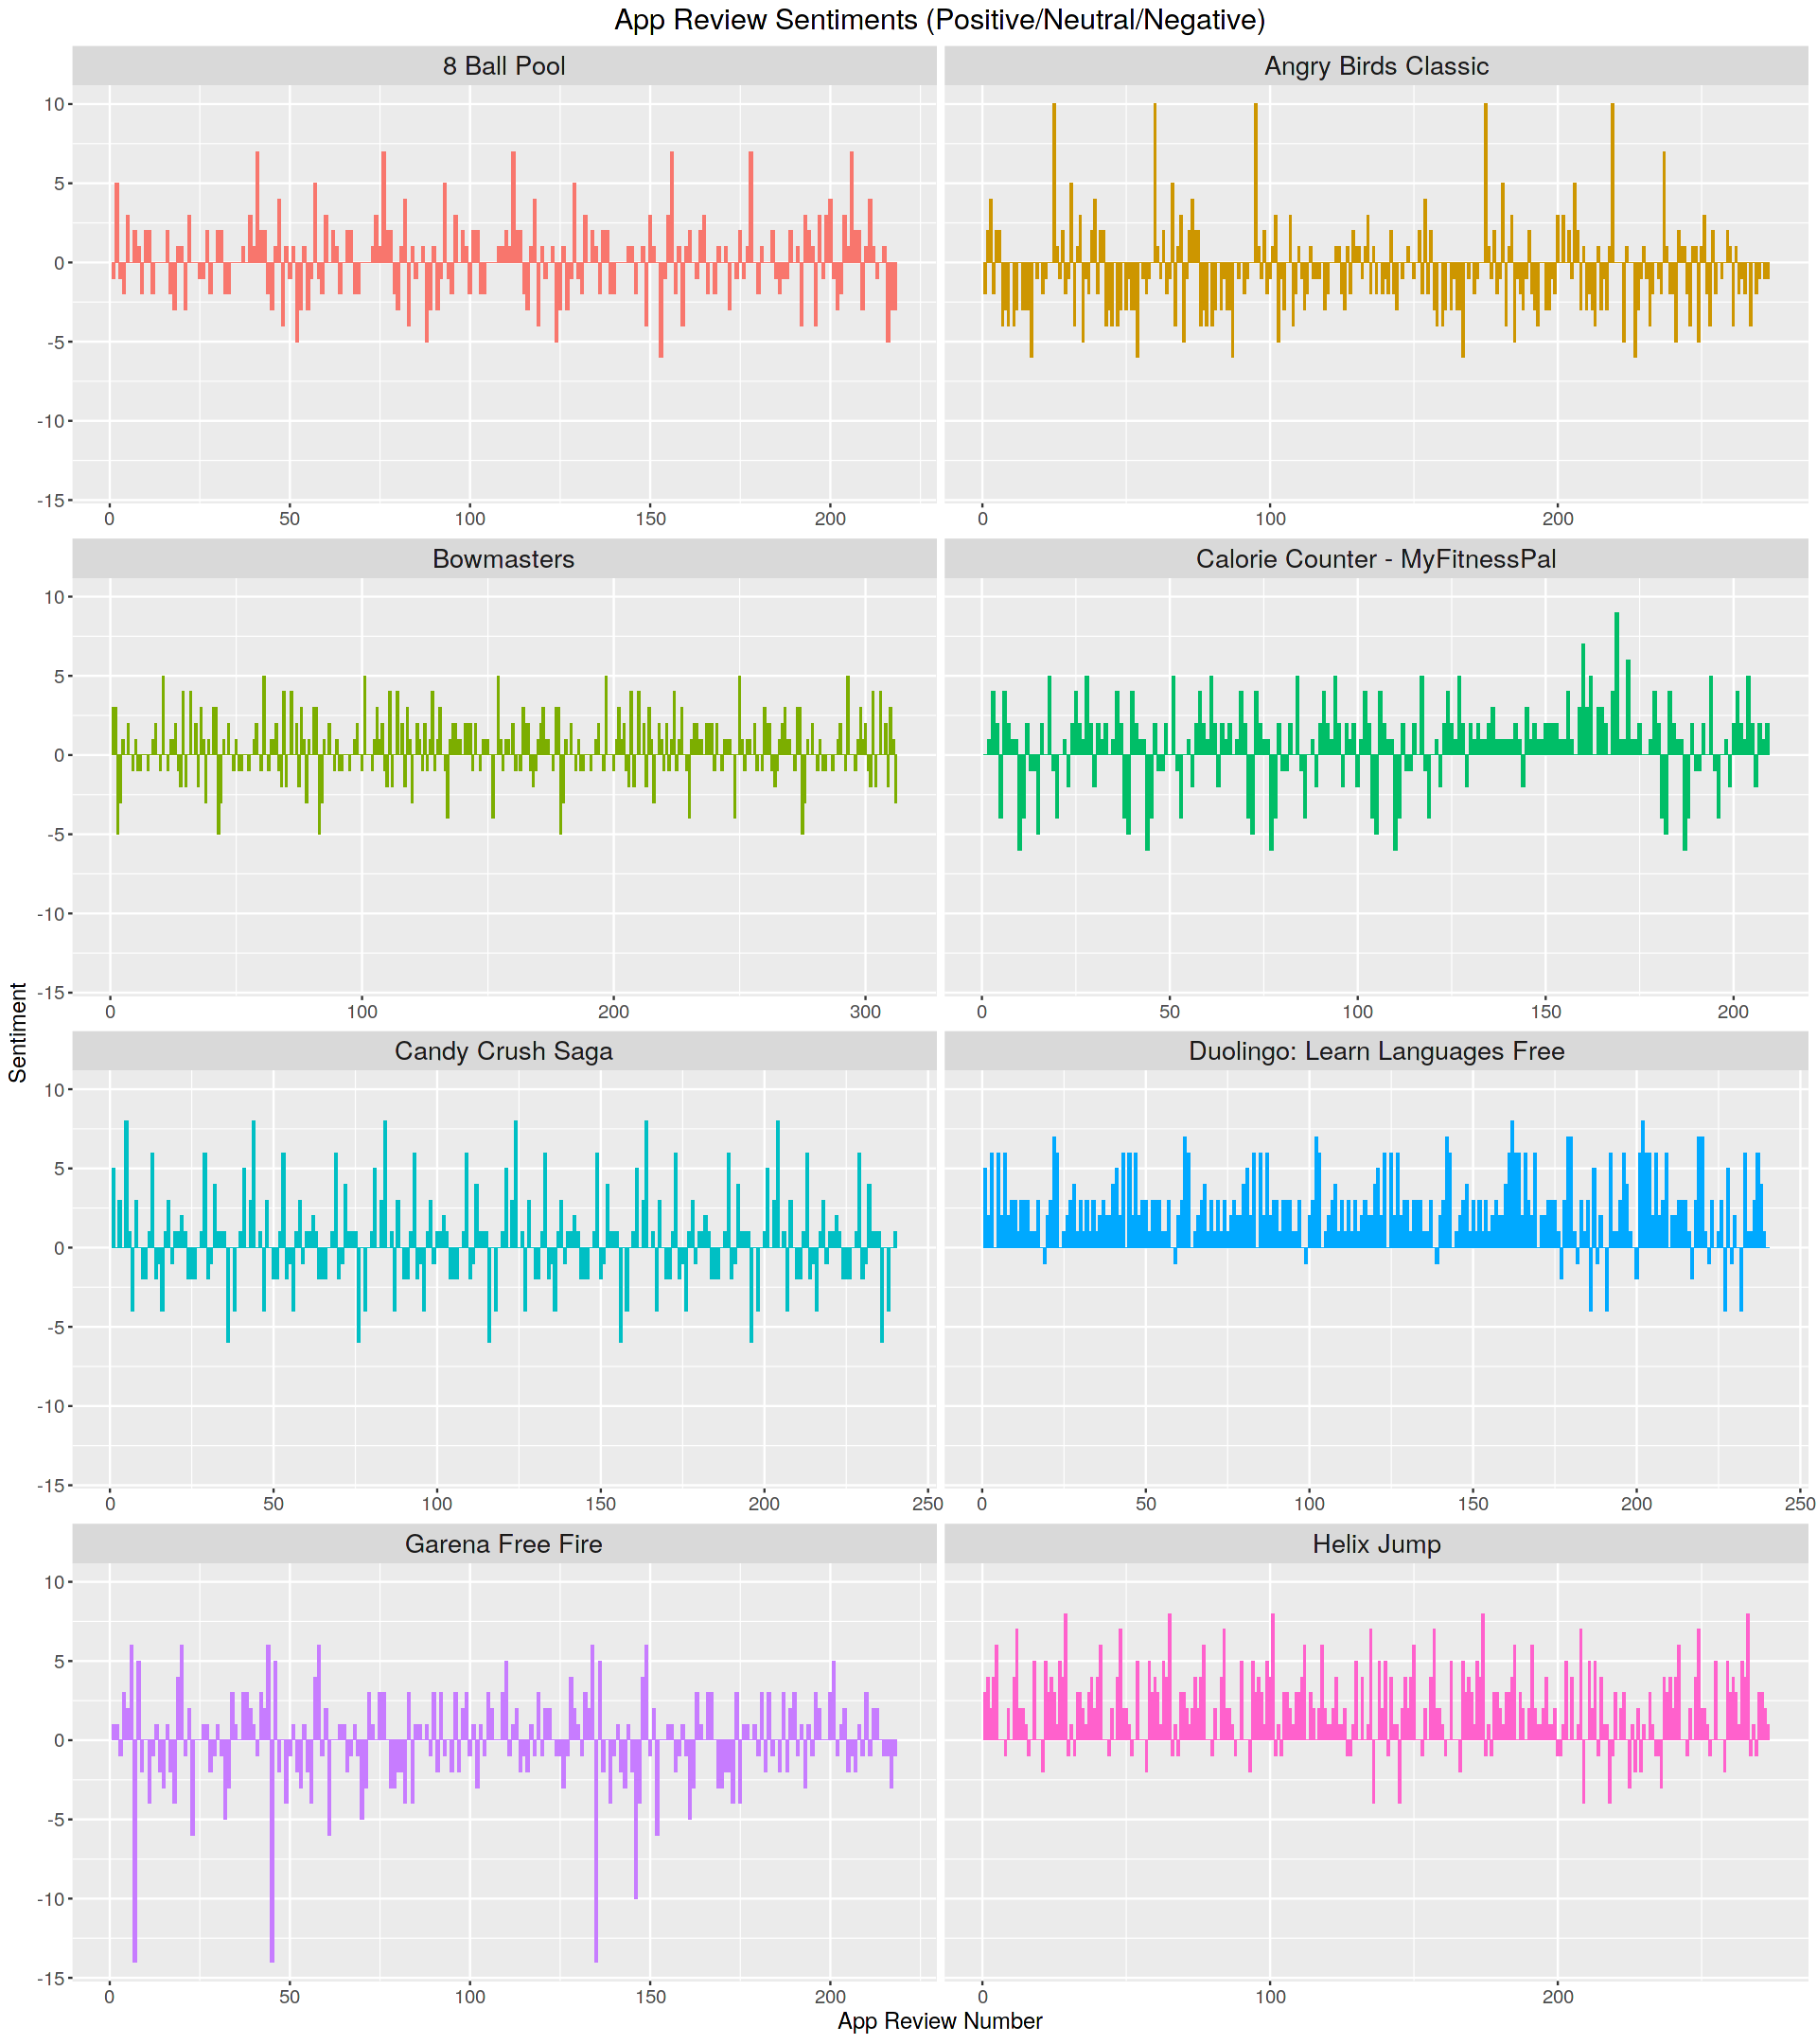

In [19]:
options(repr.plot.width=16, repr.plot.height=18)

ggplot(top_8_app_sentiment) +
  geom_bar(aes(x=appReviewID, y=sentiment, fill=App), stat="identity", show.legend=FALSE) +
  facet_wrap(~App, ncol=2, scales="free_x") + 
  theme(strip.text=element_text(size=16),
        axis.text=element_text(size=12),
        axis.title=element_text(size=14),
        plot.title=element_text(hjust=0.5, size=18)) +
  labs(x="App Review Number", 
       y="Sentiment",
       title="Review Sentiments Per App (Positive/Neutral/Negative)")

### Looking at Word Frequency in Reviews

In [20]:
get_most_common_words_for_app <- function(app_name) {
    
    most_common_words <- tokens %>%
        inner_join(get_sentiments("bing"), by="word") %>%
        filter(App == app_name) %>%
        count(word, sentiment, sort=TRUE) %>%
        mutate(word=reorder(word, n)) %>%
        head(30)
    
    plot <- ggplot(most_common_words, aes(word, n, fill=sentiment)) +
        geom_col() +
        coord_flip() +
        labs(y="Number of Occurences") +
        ggtitle(app_name) + 
        theme(axis.text=element_text(size=11),
              axis.title=element_text(size=12),
              plot.title=element_text(hjust=0.5, size=14))
      
    return(plot)
}

### Most Common Words Across All Reviews

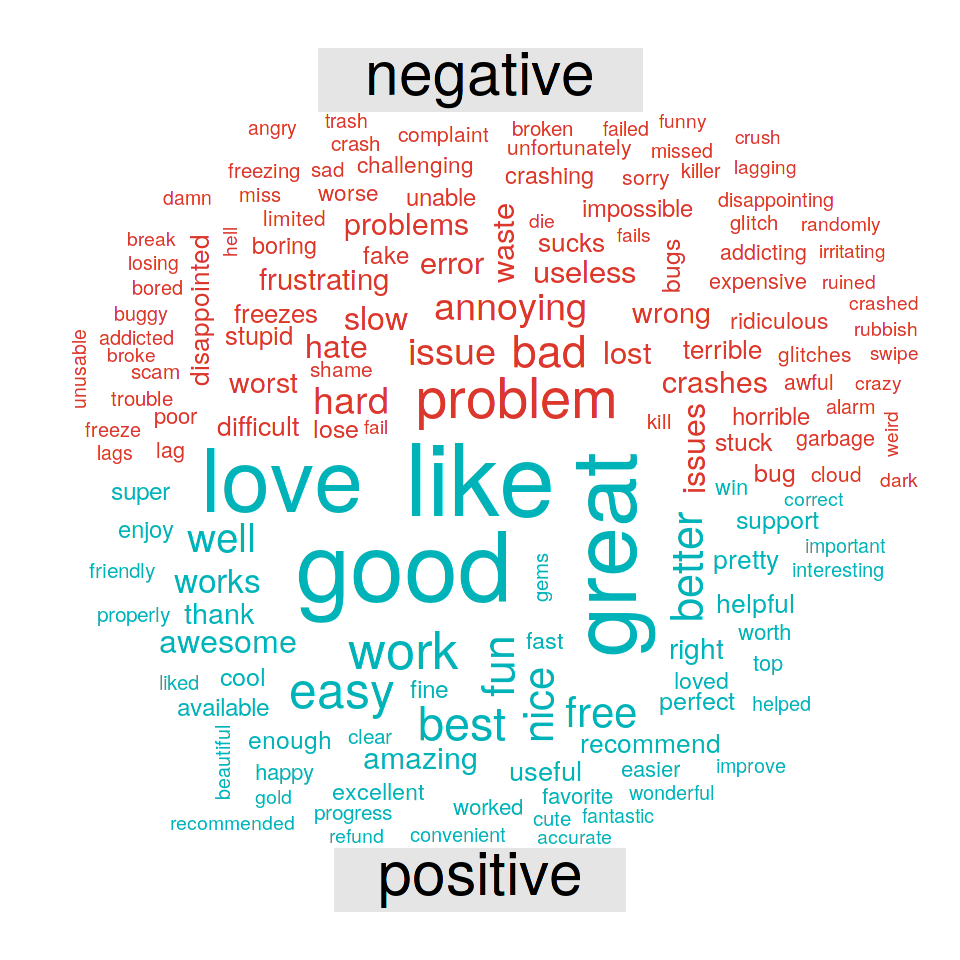

In [131]:
options(repr.plot.width=8, repr.plot.height=8)


tokens %>%
  inner_join(get_sentiments("bing"), by="word") %>%
  count(word, sentiment, sort=TRUE) %>%
  acast(word ~ sentiment, value.var="n", fill=0) %>%
  comparison.cloud(colors=c("#db372c", "#00b3b8"),
                   scale=c(5, 0.8), 
                   max.words=150)

### Most Commons Words in Top 8 Most Reviewed Apps

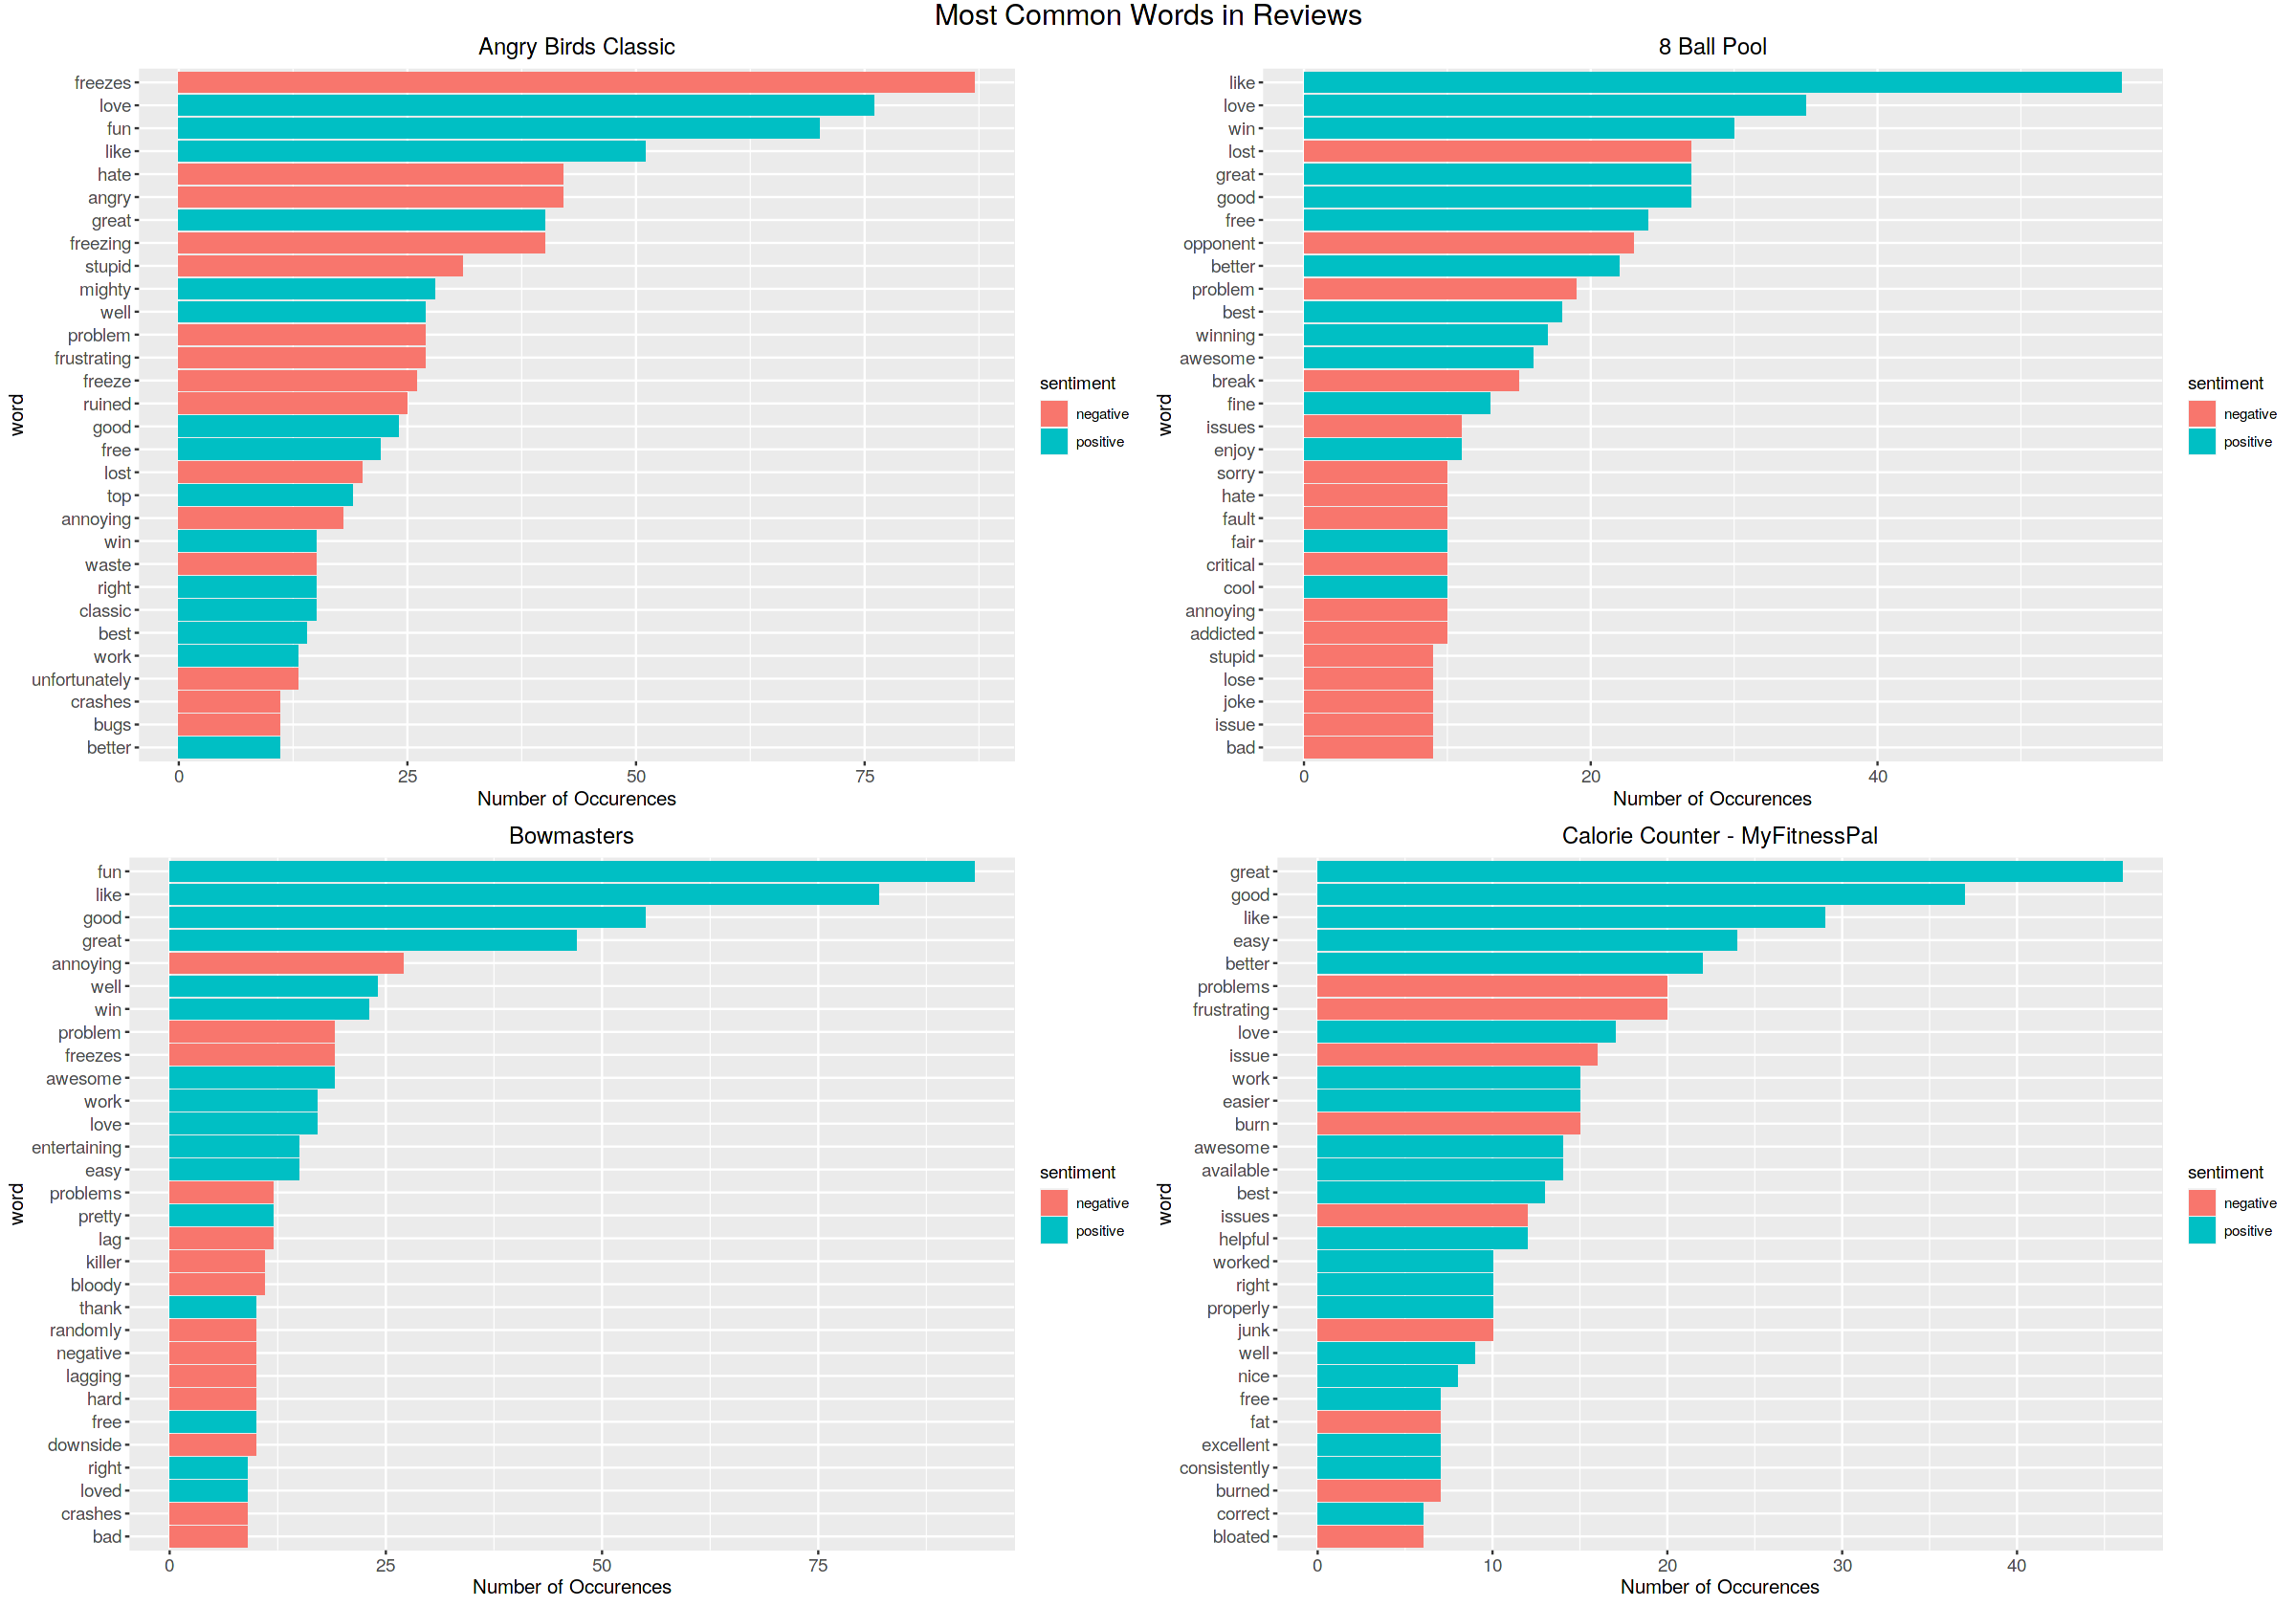

In [21]:
options(repr.plot.width=20, repr.plot.height=14)

angrybirds <- get_most_common_words_for_app("Angry Birds Classic")
ballpool <- get_most_common_words_for_app("8 Ball Pool")
bowmasters <- get_most_common_words_for_app("Bowmasters")
myfitnesspal <- get_most_common_words_for_app("Calorie Counter - MyFitnessPal")

ggarrange(angrybirds, ballpool, bowmasters, myfitnesspal, nrow=2, ncol=2) + 
    ggtitle("Most Common Words in Reviews Per App") +
    theme(plot.title=element_text(hjust=0.5, size=18))

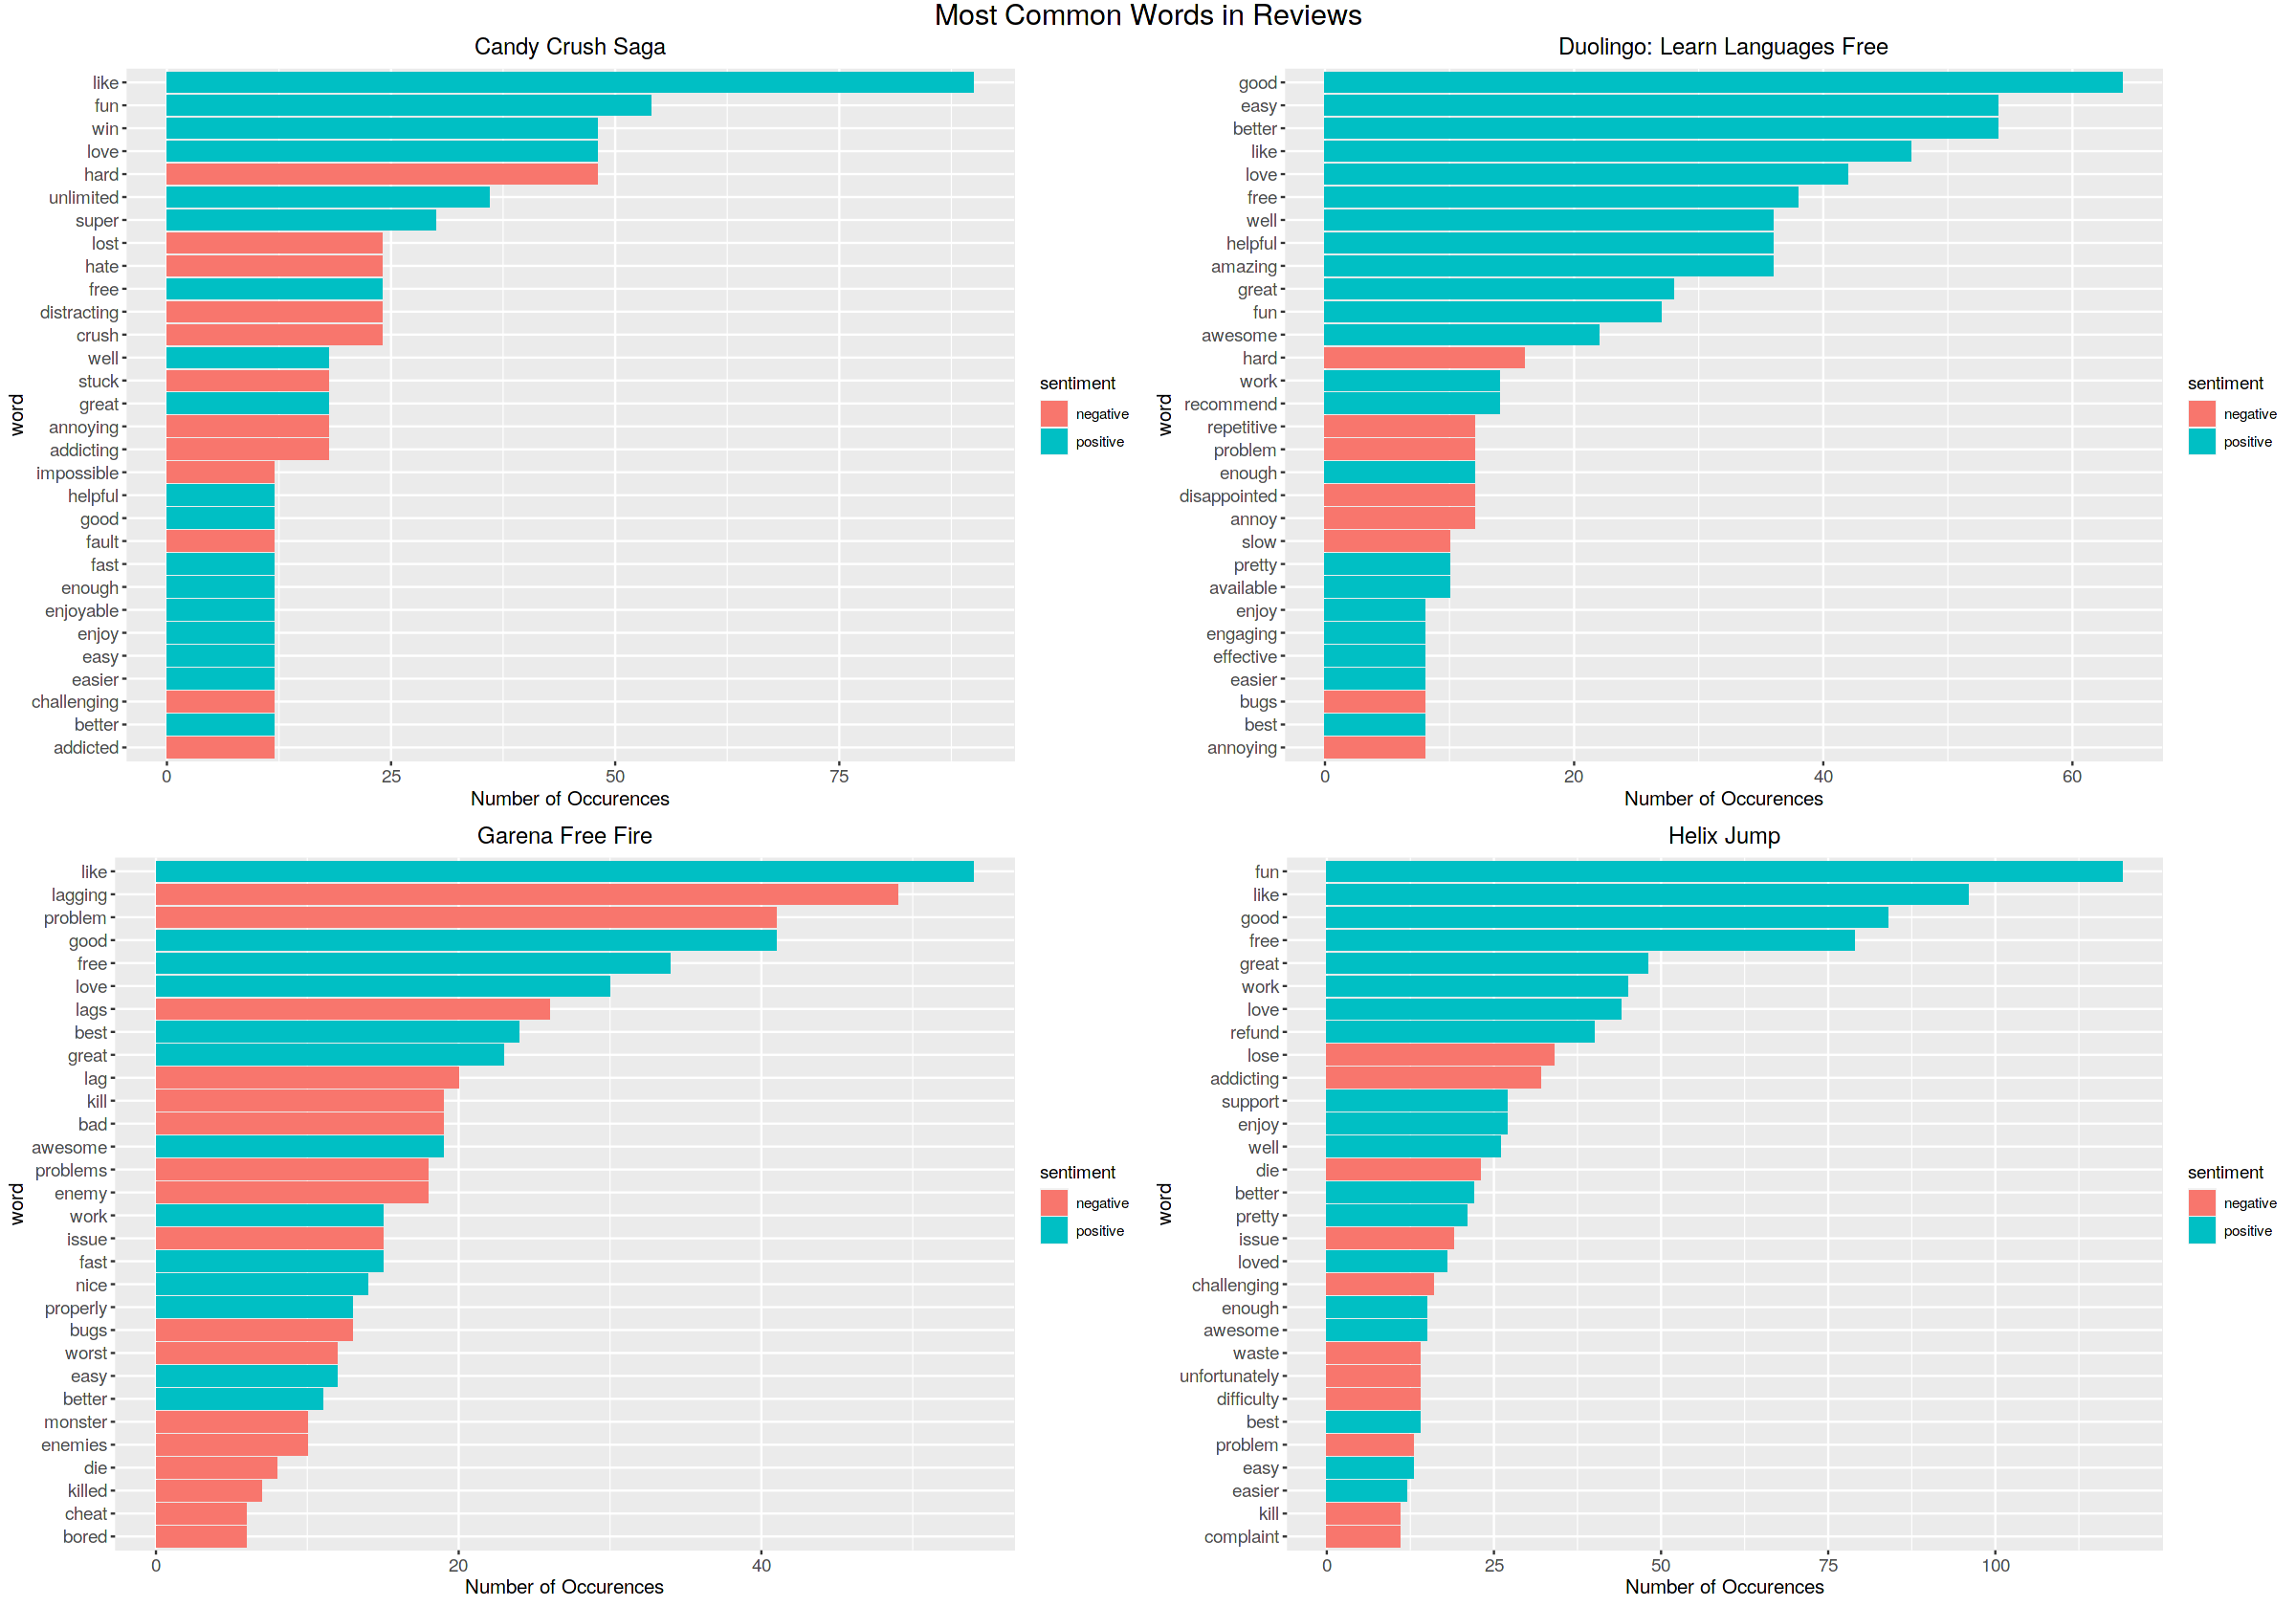

In [22]:
options(repr.plot.width=20, repr.plot.height=14)

candycrush <- get_most_common_words_for_app("Candy Crush Saga")
duolingo <- get_most_common_words_for_app("Duolingo: Learn Languages Free")
garena <- get_most_common_words_for_app("Garena Free Fire")
helixjump <- get_most_common_words_for_app("Helix Jump")

ggarrange(candycrush, duolingo, garena, helixjump, nrow=2, ncol=2) + ggtitle("Most Common Words in Reviews") + 
    ggtitle("Most Common Words in Reviews") +
    theme(plot.title=element_text(hjust=0.5, size=18))

### Looking at Mean Sentiment of Reviews For Each App

In [23]:
app_mean_sentiments <- app_sentiment %>%
    group_by(App) %>%
    summarise(mean_sentiment=mean(sentiment), .groups="keep") %>%
    arrange(desc(mean_sentiment))

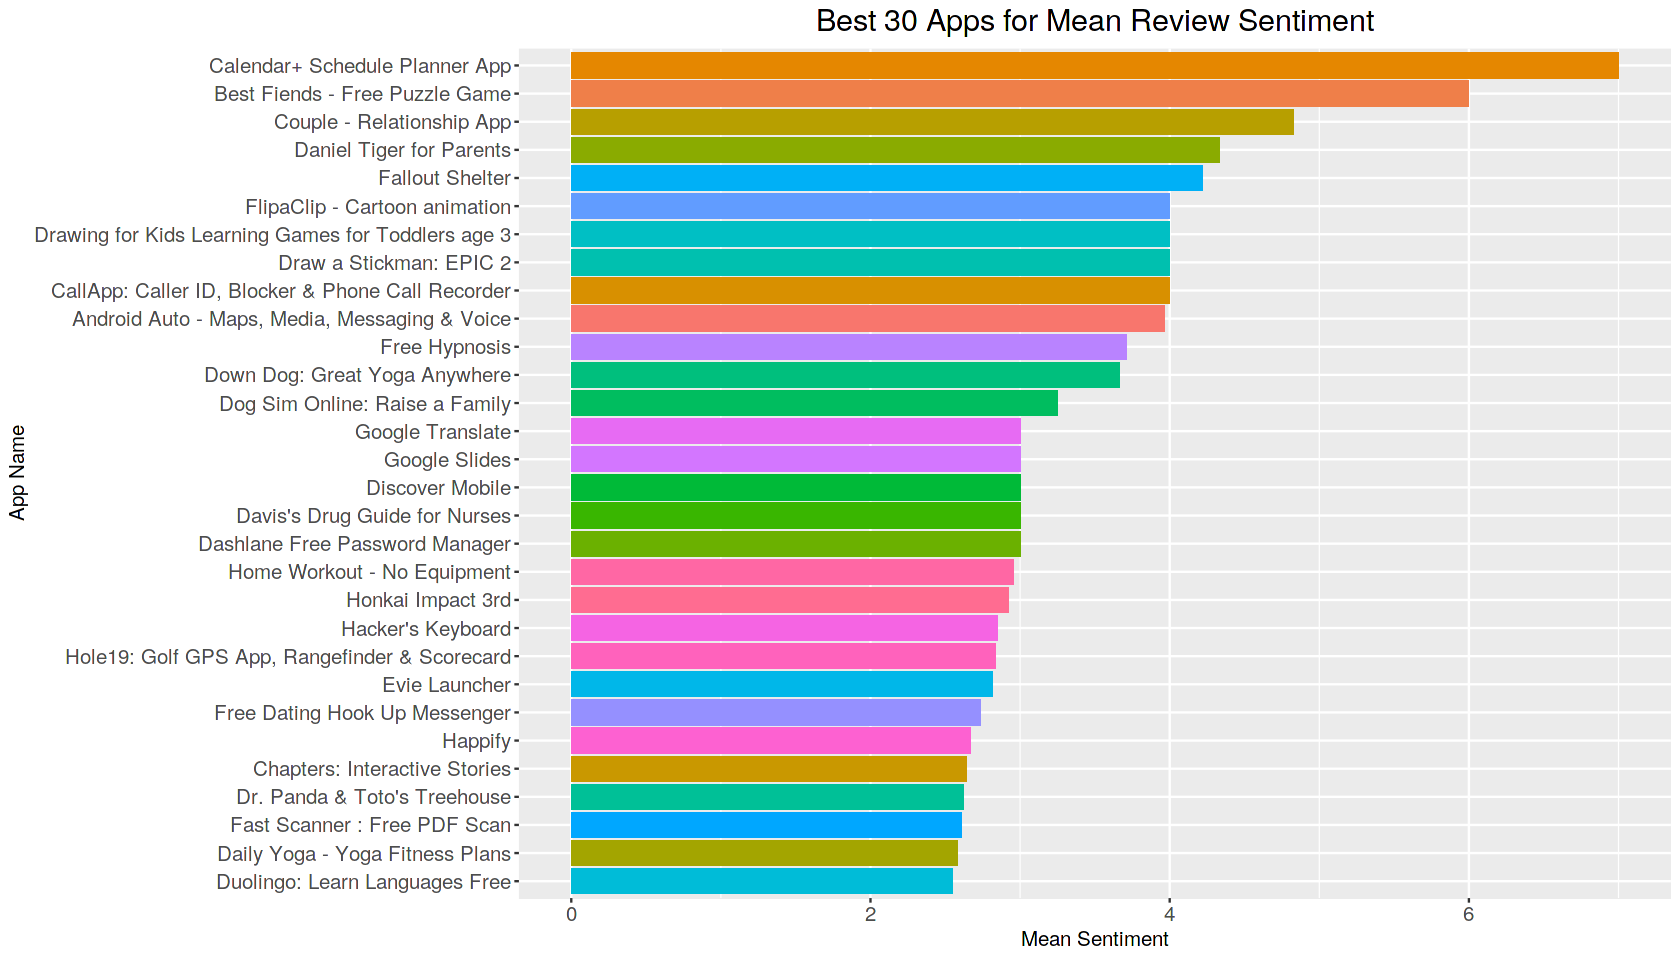

In [24]:
options(repr.plot.width=14, repr.plot.height=8)

best_app_mean_sentiments <- head(app_mean_sentiments, 30)

ggplot(best_app_mean_sentiments, aes(reorder(App, mean_sentiment), mean_sentiment, fill=App)) +
    geom_col(show.legend=FALSE) +
    coord_flip() + 
    theme(axis.text=element_text(size=12),
          axis.title=element_text(size=12),
          plot.title=element_text(hjust=0.5, size=18)) +
    labs(y="Mean Sentiment", 
         x="App Name", 
         title="Best 30 Apps for Mean Review Sentiment")

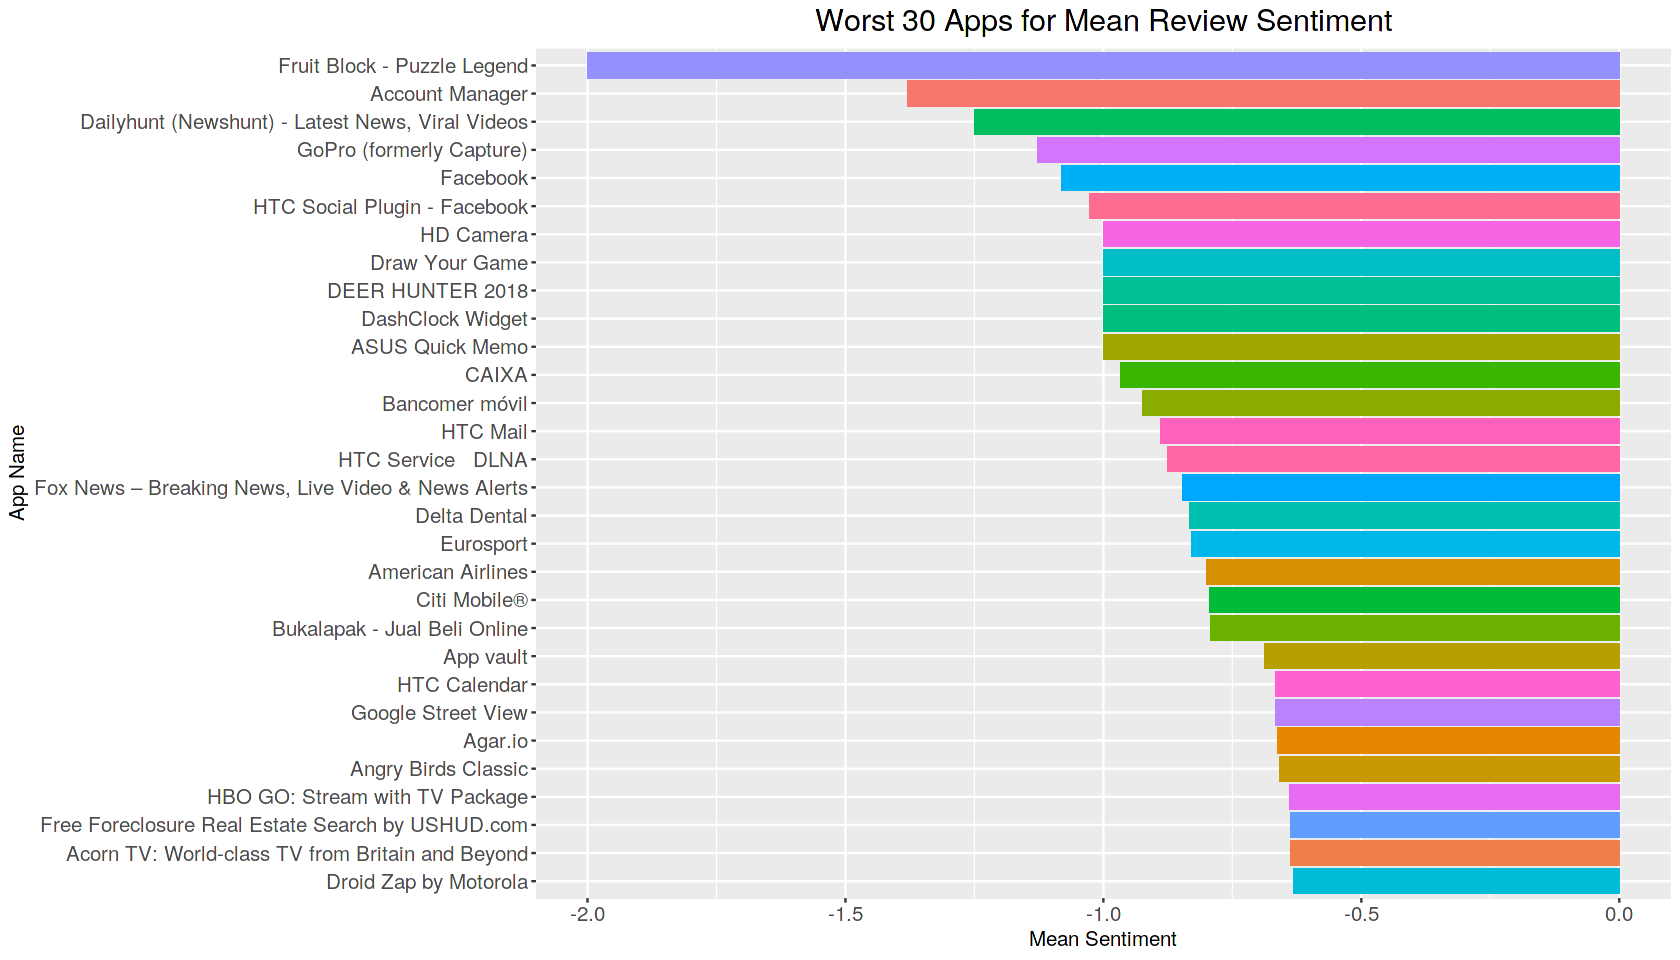

In [25]:
options(repr.plot.width=14, repr.plot.height=8)

worst_app_mean_sentiments <- tail(app_mean_sentiments, 30)

ggplot(worst_app_mean_sentiments, aes(reorder(App, -mean_sentiment), mean_sentiment, fill=App)) +
    geom_col(show.legend=FALSE) +
    coord_flip() + 
    theme(axis.text=element_text(size=12),
          axis.title=element_text(size=12),
          plot.title=element_text(hjust=0.5, size=18)) +
    labs(y="Mean Sentiment", 
         x="App Name", 
         title="Worst 30 Apps for Mean Review Sentiment")